In [15]:
using LinearAlgebra
using Combinatorics
using Statistics
using PyPlot
using BenchmarkTools
using Profile

using Symbolics

In [16]:
function n_choose_k(n, k)
    if k==0
        return [Bool[0 for _ in 1:n]]
    elseif k==n
        return [Bool[1 for _ in 1:n]]
    else
        a = n_choose_k(n-1, k)
        b = n_choose_k(n-1, k-1)
        return [
            [Bool[0, i...] for i in a]..., 
            [Bool[1, i...] for i in b]...
        ]
    end
end
    
function ind2mask(indices, n)
    mask = zeros(Bool, 2^n)
    for i in indices
        for j in 0 : 2^i : (2^n-2^i)
            mask[j+1:j+2^(i-1)] .⊻= true
        end
    end
    return mask
end


function diag_rand_U1(n, k)
    eles = zeros(2^n)
    for l in 1:k
        for indices in combinations(1:n, l)
            x = rand()
            mask = zeros(Bool, 2^n)
            for i in indices
                for j in 0 : 2^i : (2^n-2^i)
                    mask[j+1:j+2^(i-1)] .⊻= true
                end
            end
            eles[mask] .+= x
            eles[.!mask] .-= x
        end
    end
    return exp.(1im .* 2pi .* eles)
end
    

function diag_rand_U2(n, k)
    eles = Diagonal([0 for _ in 1:2^n])
    Z  = Diagonal([1, -1])
    II = Diagonal([1,  1])
    for l in 1:k
        for ar in n_choose_k(n, l)
            x = rand()
            eles += x * kron([b ? Z : II for b in ar]...)
        end
    end
    return exp.(1im .* 2pi .* eles.diag)
end

function diag_frame_potential_estim1(n, k, ts, avg)
    tmp = [abs(
                sum(diag_rand_U1(n, k))
                )
        for _ in 1:avg]
    return [mean(tmp.^(2t)) for t in ts], [std(tmp.^(2t)) / sqrt(avg) for t in ts]
end

function diag_frame_potential_estim2(n, k, ts, avg)
    tmp = [abs(
                sum(diag_rand_U2(n, k))
                )
        for _ in 1:avg]
    return [mean(tmp.^(2t)) for t in ts], [std(tmp.^(2t)) / sqrt(avg) for t in ts]
end

function test_true_frame_potential_estim(n, ts, avg)
    tmp = [abs(
                sum([exp(2pi * 1im * rand()) for _ in 1:2^n])
                ) / 2^(n/2)
        for _ in 1:avg]
    return [mean(tmp.^(2t)) for t in ts], [std(tmp.^(2t)) / sqrt(avg) for t in ts]
end

test_true_frame_potential_estim (generic function with 1 method)

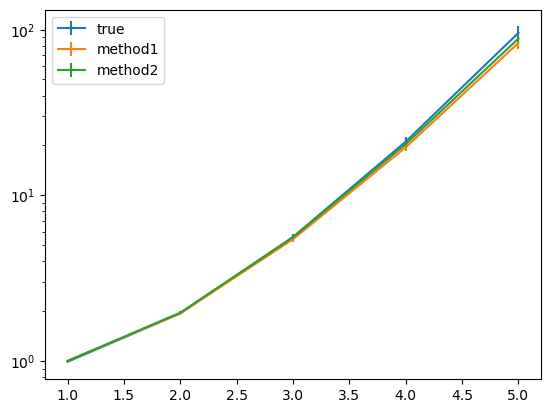

PyObject <matplotlib.legend.Legend object at 0x000000004F697850>

In [12]:
n = 5
k = n
ts = 1:5
avg = 10000

y1, e1 = test_true_frame_potential_estim(n, ts, avg)
y2, e2 = diag_frame_potential_estim1(n, k, ts, avg) 
y3, e3 = diag_frame_potential_estim2(n, k, ts, avg)

x = ts
errorbar(x, y1, yerr=e1, label="true")
errorbar(x, y2, yerr=e2, label="method1")
errorbar(x, y3, yerr=e3, label="method2")


yscale("log")
legend()

In [101]:
@btime diag_frame_potential_estim1(6, 3, [2], 100)
@btime diag_frame_potential_estim2(6, 3, [2], 100)

  9.380 ms (138206 allocations: 16.44 MiB)
  13.785 ms (185116 allocations: 17.13 MiB)


([8210.087308743094], [1447.9530776982933])

In [32]:
n = 6
ks = 1:n
ts = 2:4
avg = 10000

tmp1 = [diag_frame_potential_estim1(n, k, ts, avg) for k in ks]
tmp2 = [diag_frame_potential_estim2(n, k, ts, avg) for k in ks]

6-element Array{Tuple{Array{Float64,1},Array{Float64,1}},1}:
 ([11.32359189258274, 236.29952481741904, 6681.723750343313], [0.8095773855868754, 29.21603967391721, 1228.773185569458])
 ([1.9821739361820156, 5.916940370068807, 24.498184541747033], [0.04535551581812609, 0.31735608384244407, 3.213941169455883])
 ([2.0134983605535663, 6.024465470311085, 24.367601772544873], [0.04507267206452266, 0.28367320085463194, 2.388595838180216])
 ([1.972154055267969, 5.791376352634025, 22.545154007589538], [0.043194476675490485, 0.24523836717578312, 1.755233622102816])
 ([1.9552757028228345, 5.588842662217546, 20.47011528611273], [0.04080279044351179, 0.20425369441296218, 1.2238814632605242])
 ([2.0086592139631074, 5.986897790456912, 23.262854915334792], [0.043852099247475386, 0.2361587407999351, 1.5230846450806175])

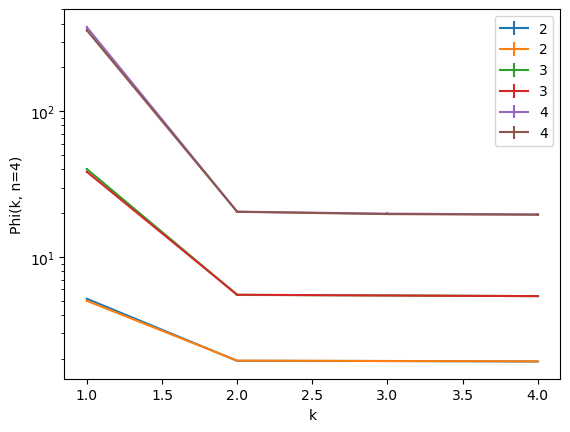

PyObject <matplotlib.legend.Legend object at 0x0000000042661E20>

In [31]:
for (i,t) in enumerate(ts)
    y1, e1 = [a[1][i] for a in tmp1], [a[2][i] for a in tmp1]
    y2, e2 = [a[1][i] for a in tmp2], [a[2][i] for a in tmp2]
    x = ks
    errorbar(x, y1, yerr=e1, label=string(t))
    errorbar(x, y2, yerr=e2, label=string(t))
end

yscale("log")
xlabel("k")
ylabel("Phi(k, n=4)")
legend()

In [29]:
tmp2

4-element Array{Tuple{Array{Float64,1},Array{Float64,1}},1}:
 ([5.012479229519372, 38.47921321709213, 359.6574788997936], [0.05783907643040237, 0.6399952594603849, 7.798663513504485])
 ([1.9508196862412623, 5.524201998152323, 20.470133396439735], [0.012909145050792178, 0.06965833433613633, 0.47678521491870823])
 ([1.9371202054202068, 5.453309148884202, 19.73453261397249], [0.012642095453801449, 0.06333782774159388, 0.38040352658242793])
 ([1.9283514108645337, 5.40131169035059, 19.54490625538273], [0.012580351885719675, 0.06406885862303688, 0.3991154693578115])

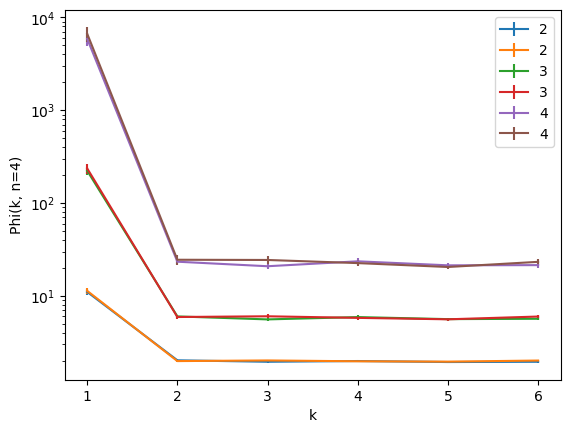

PyObject <matplotlib.legend.Legend object at 0x00000000426069A0>

In [33]:
for (i,t) in enumerate(ts)
    y1, e1 = [a[1][i] for a in tmp1], [a[2][i] for a in tmp1]
    y2, e2 = [a[1][i] for a in tmp2], [a[2][i] for a in tmp2]
    x = ks
    errorbar(x, y1, yerr=e1, label=string(t))
    errorbar(x, y2, yerr=e2, label=string(t))
end

yscale("log")
xlabel("k")
ylabel("Phi(k, n=4)")
legend()

In [11]:
sampler1(d1, d2, d3) = exp.(1im * 2pi * (kron(rand(d1*d2), ones(d3)) + kron(ones(d1), rand(d2*d3))))
sampler2(d1, d2, d3) = exp.(1im * 2pi * rand(d1*d2*d3))
sampler3(d1, d2, d3) = exp.(1im * 2pi * (kron(rand(d1*d2), ones(d3)) + kron(ones(d1), rand(d2), ones(d3)) + kron(ones(d1), rand(d2*d3))))


begin
    avg = 1000000
    d1,d2,d3 = 2,2,2
    max_t = 2

    samples1 = [abs(sum(sampler1(d1,d2,d3))) for _ in 1:avg]
    # samples2 = [abs(sum(sampler2(d1,d2,d3))) for _ in 1:avg]
    samples3 = [abs(sum(sampler2(d1,d2,d3))) for _ in 1:avg]

    @show [mean(samples1.^(2t)) for t in 1:max_t]
    # @show [mean(samples2.^(2t)) for t in 1:max_t]
    @show [mean(samples3.^(2t)) for t in 1:max_t]

end;

[mean(samples1 .^ (2t)) for t = 1:max_t] = [7.992324777530755, 135.60713642178152]
[mean(samples3 .^ (2t)) for t = 1:max_t] = [7.989637871596435, 119.80075963936285]


In [34]:
tmp2

6-element Array{Tuple{Array{Float64,1},Array{Float64,1}},1}:
 ([11.32359189258274, 236.29952481741904, 6681.723750343313], [0.8095773855868754, 29.21603967391721, 1228.773185569458])
 ([1.9821739361820156, 5.916940370068807, 24.498184541747033], [0.04535551581812609, 0.31735608384244407, 3.213941169455883])
 ([2.0134983605535663, 6.024465470311085, 24.367601772544873], [0.04507267206452266, 0.28367320085463194, 2.388595838180216])
 ([1.972154055267969, 5.791376352634025, 22.545154007589538], [0.043194476675490485, 0.24523836717578312, 1.755233622102816])
 ([1.9552757028228345, 5.588842662217546, 20.47011528611273], [0.04080279044351179, 0.20425369441296218, 1.2238814632605242])
 ([2.0086592139631074, 5.986897790456912, 23.262854915334792], [0.043852099247475386, 0.2361587407999351, 1.5230846450806175])

In [3]:
n_choose_k(4,2)

6-element Array{Array{Bool,1},1}:
 [0, 0, 1, 1]
 [0, 1, 0, 1]
 [0, 1, 1, 0]
 [1, 0, 0, 1]
 [1, 0, 1, 0]
 [1, 1, 0, 0]

In [7]:
function diag_theta_expr(n, k)
    all_terms = cat([collect(combinations(1:n, l)) for l in 1:k]..., dims=1)
    nn = length(all_terms)
    @variables iθ[1:nn]
    expr = zeros(Num, 2^n)
    for (i, indices) in enumerate(all_terms)
        mask = ind2mask(indices, n)
        expr += iθ[i] * mask
    end
    return expr
end

function diag_theta_expr_assign(n, all_terms)
    nn = length(all_terms)
    @variables iθ[1:nn]
    expr = zeros(Num, 2^n)
    for (i, indices) in enumerate(all_terms)
        mask = ind2mask(indices, n)
        expr += iθ[i] * mask
    end
    return expr
end


function sum_of_exp_expr_mult(a, b)
    result = Num[]
    for e1 in a
        for e2 in b
            tmp = e1+e2
            push!(result, tmp)
        end
    end
    return result
end


function diag_frame_potential_cal(n, k, max_t)
    trU  = diag_theta_expr(n, k)
    abs_trU_2 = sum_of_exp_expr_mult(trU, -trU)
    tmp = [zero(Num)]
    result = zeros(Int64, max_t)
    for t in 1:max_t
        tmp = sum_of_exp_expr_mult(tmp, abs_trU_2)
        result[t] = count(x -> typeof(x.val)==Int64, tmp)
    end
    return result
end

diag_frame_potential_cal (generic function with 1 method)

In [31]:
n = 3
# k = 3
max_t = 3

[diag_frame_potential_cal(n, k, max_t) for k in 1:n]

3-element Array{Array{Int64,1},1}:
 [8, 216, 8000]
 [8, 120, 2528]
 [8, 120, 2528]

In [15]:
Profile.init(n=10^7)
Profile.clear()

@profile [diag_frame_potential_cal(n, k, max_t) for k in 1:4]

4-element Array{Array{Int64,1},1}:
 [32, 7776]
 [32, 2016]
 [32, 2016]
 [32, 2016]

In [8]:
diag_frame_potential_estim1(n, k, 1:2, 1000000)[1]

2-element Array{Float64,1}:
  16.006837942882527
 496.023124284127

In [56]:
n = 3
k=2
cat([collect(combinations(1:n, l)) for l in 1:k]..., dims=1)

6-element Array{Array{Int64,1},1}:
 [1]
 [2]
 [3]
 [1, 2]
 [1, 3]
 [2, 3]

In [ ]:
n = 4
k = 2
max_t = 3

# diag_frame_potential_cal(n, k, max_t)
tmp = begin
    trU  = diag_theta_expr(n, k)
    abs_trU_2 = sum_of_exp_expr_mult(trU, -trU)
    tmp = [zero(Num)]
    result = zeros(Int64, max_t)
    for t in 1:max_t
        tmp = sum_of_exp_expr_mult(tmp, abs_trU_2)
    end
    tmp
end

In [28]:
length(tmp)

256

In [ ]:
n = 3
# k = 3
# max_t = 3

@show diag_frame_potential_cal(n, 2, 4)
@show diag_frame_potential_cal(n, n, 4)